<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/end_to_end(modelA%EF%BC%8BB%EF%BC%8BC)V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import joblib
from torch import nn
from tqdm import tqdm_notebook as tqdm
#!pip install autorch
import autorch
import random
import torch

config = {'seed':11}
np.random.seed(config["seed"])
random.seed(config["seed"])
torch.manual_seed(config["seed"])
torch.cuda.manual_seed(config["seed"])

In [ ]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/phase2/dataset/col_names.pkl')
c.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'yld', 'Tray_temp', 'duty', 'Rate_m3', 'Rate_ton', 'sle', 'shc', 'she', 'case'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase2/dataset/train.csv',index_col=0)
df = df.dropna(axis=0).astype('float32')
df.head(3)

,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,Naphtha Properties_n-Pentane_wt%,Naphtha Properties_tr2-Pentene_wt%,Naphtha Properties_Cyclopentane_wt%,Naphtha Properties_3-Methylpentane_wt%,Naphtha Properties_tr2-Hexene_wt%,Naphtha Properties_n-Hexane_wt%,Naphtha Properties_Methylcyclopentane_wt%,"Naphtha Properties_2,2-Dimethylpentane_wt%",Naphtha Properties_Benzene_wt%,Naphtha Properties_Cyclohexane_wt%,"Naphtha Properties_2,2,3-Trimethylbutane_wt%",Naphtha Properties_4-Methyl-1-hexene_wt%,Naphtha Properties_2-Methylhexane_wt%,"Naphtha Properties_t-1,3-Dimethylcyclopentane_wt%",Naphtha Properties_n-Heptane_wt%,Naphtha Properties_H2O_wt%,Naphtha Properties_Methylcyclohexane_wt%,Naphtha Properties_Ethylcyclopentane_wt%,"Naphtha Properties_2,3-Dimethyl-1-hexene_wt%",Naphtha Properties_Toluene_wt%,Naphtha Properties_2-Methylheptane_wt%,Naphtha Properties_n-Octane_wt%,Naphtha Properties_Ethylcyclohexane_wt%,Naphtha Properties_EthylBenzene_wt%,Naphtha Properties_P-Xylene_wt%,Naphtha Properties_M-Xylene_wt%,Naphtha Properties_O-Xylene_wt%,Naphtha Properties_2-Methyloctane_wt%,Naphtha Properties_1-Nonene_wt%,Naphtha Properties_n-Nonane_wt%,Naphtha Properties_i-Propylbenzene_wt%,"Naphtha Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Naphtha Properties_n-Propylcyclohexane_wt%,Naphtha Properties_n-Propylbenzene_wt%,...,Individual Component to Heavy End Split Factor_2-Methylhexane_Ratio,"Individual Component to Heavy End Split Factor_t-1,3-Dimethylcyclopentane_Ratio",Individual Component to Heavy End Split Factor_n-Heptane_Ratio,Individual Component to Heavy End Split Factor_H2O_Ratio,Individual Component to Heavy End Split Factor_Methylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_Ethylcyclopentane_Ratio,"Individual Component to Heavy End Split Factor_2,3-Dimethyl-1-hexene_Ratio",Individual Component to Heavy End Split Factor_Toluene_Ratio,Individual Component to Heavy End Split Factor_2-Methylheptane_Ratio,Individual Component to Heavy End Split Factor_n-Octane_Ratio,Individual Component to Heavy End Split Factor_Ethylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_EthylBenzene_Ratio,Individual Component to Heavy End Split Factor_P-Xylene_Ratio,Individual Component to Heavy End Split Factor_M-Xylene_Ratio,Individual Component to Heavy End Split Factor_O-Xylene_Ratio,Individual Component to Heavy End Split Factor_2-Methyloctane_Ratio,Individual Component to Heavy End Split Factor_1-Nonene_Ratio,Individual Component to Heavy End Split Factor_n-Nonane_Ratio,Individual Component to Heavy End Split Factor_i-Propylbenzene_Ratio,"Individual Component to Heavy End Split Factor_1-trans-3,5-Trimethylcyclohexane_Ratio",Individual Component to Heavy End Split Factor_n-Propylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_n-Propylbenzene_Ratio,"Individual Component to Heavy End Split Factor_1,3,5-Trimethylbenzene_Ratio",Individual Component to Heavy End Split Factor_1-Methyl-2-ethylbenzene_Ratio,"Individual Component to Heavy End Split Factor_1,2,3-Trimethylbenzene_Ratio","Individual Component to Heavy End Split Factor_2,4-Dimethyloctane_Ratio","Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane_Ratio",Individual Component to Heavy End Split Factor_3-Methylnonane_Ratio,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_n-Decane_Ratio,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,Case Conditions_C7+ in Light End 

In [ ]:
# X
X = df[c['case']+c['xna']]
print('X.shape',X.shape)

# modelA的Y
Y1 = df[c['sle']+c['shc']+c['she']]
print('Y1.shape',Y1.shape)

duty = df[c['duty']]
density = pd.DataFrame(df[c['Rate_ton']].values/df[c['Rate_m3']].values,
                       columns=['NA_density','LE_density','HC_density','HE_density'],
                       index=df.index)
# modelB的Y
Y2 = duty.join(density)
print('Y2.shape',Y2.shape)

# modelC的Y
Y3 = df[c['Tray_temp']+c['fna']+c['yld']]
print('Y3.shape',Y3.shape)

# (modelA + modelB + modelC)的Y
Y = Y1.join(Y2).join(Y3)
print('Y.shape',Y.shape)

X.shape (16498, 58)
Y1.shape (16498, 162)
Y2.shape (16498, 7)
Y3.shape (16498, 8)
Y.shape (16498, 177)


In [ ]:
wt = df[c['xle']+c['xhc']+c['xhe']]
df = X.join(Y).join(wt)
x_col = X.columns.tolist()
y_col = Y.columns.tolist()

In [ ]:
normalize_idx_list = []
for i in range(54):
  normalize_idx_list.append([y_col.index(c['sle'][i]),
                             y_col.index(c['shc'][i]),
                             y_col.index(c['she'][i])])
for idx in tqdm(normalize_idx_list):
  assert np.allclose(df[y_col].iloc[:,idx].sum(axis=1),1) # 因為分離係數要確保質量平衡
print('pass')


pass


  0%|          | 1/300 [00:00<03:33,  1.40it/s]

epoch:0 train_loss:0.0064 valid_loss:0.0017


 17%|█▋        | 51/300 [00:36<02:58,  1.40it/s]

epoch:50 train_loss:0.0002 valid_loss:0.0002


 34%|███▎      | 101/300 [01:12<02:23,  1.39it/s]

epoch:100 train_loss:0.0001 valid_loss:0.0001


 50%|█████     | 151/300 [01:48<01:46,  1.39it/s]

epoch:150 train_loss:0.0001 valid_loss:0.0001


 67%|██████▋   | 201/300 [02:24<01:10,  1.40it/s]

epoch:200 train_loss:0.0000 valid_loss:0.0000


 84%|████████▎ | 251/300 [03:00<00:34,  1.40it/s]

epoch:250 train_loss:0.0000 valid_loss:0.0000


100%|██████████| 300/300 [03:36<00:00,  1.38it/s]


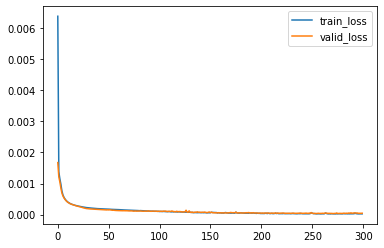

In [ ]:
model = autorch.utils.PartBulider(df,x_col,y_col,normalize_idx_list=normalize_idx_list,device='cuda:0',cut_way=[0.82,0.92]) # 使用 gpu train 快一些
model.loss_fn = nn.SmoothL1Loss() # SmoothL1增加穩健性
model.train()

# predict

In [ ]:
x_test = model.data['X_test']
sp_pred,op_pred = model.predict(x_test).iloc[:,:162],model.predict(x_test).iloc[:,162:] # predict sp op

normalize_idx_list = [ [i,i+54,i+54*2] for i in range(54)]
for idx in tqdm(normalize_idx_list):
  assert np.allclose(sp_pred.iloc[:,idx].sum(axis=1),1) # check massblance
print('pass')


pass


# sp sesult

In [ ]:
sp_real = model.data['Y_test'].loc[sp_pred.index,sp_pred.columns]
res = model.show_metrics(sp_real,sp_pred,e=0.02)
res

,R2,MSE,MAPE
Individual Component to Light End Split Factor_Oxygen_Ratio,0,5.60649e-08,0.0170662
Individual Component to Light End Split Factor_Methane_Ratio,0,5.6506e-08,0.0166185
Individual Component to Light End Split Factor_Ethane_Ratio,0,5.619e-08,0.017438
Individual Component to Light End Split Factor_Propane_Ratio,0.995549,9.77667e-08,0.0201259
Individual Component to Light End Split Factor_n-Butane_Ratio,0.994649,5.69536e-07,0.0459346
...,...,...,...
Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,0.995552,1.57514e-05,0.464374
Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,0.998579,1.4759e-05,0.437909
Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,0.996789,1.58146e-05,0.447391
Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,0,5.27049e-08,0.0169146


# op result

In [ ]:
op_real = model.data['Y_test'].loc[op_pred.index,op_pred.columns]
res = model.show_metrics(op_real,op_pred,e=0.02)
res

,R2,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.993809,0.000134448,0.391192
Duty_Condenser Heat Duty_Mkcal/hr,0.993439,0.00828352,1.23968
Duty_Reboiler Heat Duty_Mkcal/hr,0.992392,0.00855476,1.11898
NA_density,0.995988,4.30035e-07,0.067689
LE_density,0.985573,1.8359e-06,0.134852
HC_density,0.995809,5.00887e-07,0.0730977
HE_density,0.991214,1.53809e-06,0.111257
Column Temp Profile_C011 Tray 15 Temp_oC,0.996017,0.0487234,0.163733
Column Temp Profile_C013 Tray 16 Temp_oC,0.990526,0.36326,0.239237
Column Temp Profile_C011 Tray 24 Temp_oC,0.993,0.07283,0.156305


# 分離係數 to 重量百分比 (sp2wt)

In [ ]:
def sp2wt(x,s):
  a = 100*x*s
  b = np.diag(x@s.T).reshape(-1,1)
  wt = a/b
  assert np.allclose(np.sum(wt,axis=1),100)
  return wt

In [ ]:
#from autorch.function import sp2wt
x_test = model.data['X_test']
y_pred = model.predict(x_test)
xna = x_test[c['xna']]
xle = sp2wt(xna.values,y_pred[c['sle']].values)
xhc = sp2wt(xna.values,y_pred[c['shc']].values)
xhe = sp2wt(xna.values,y_pred[c['she']].values)
wt_pred = np.hstack((xle,xhc,xhe))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=c['xle']+c['xhc']+c['xhe'])
wt_pred.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,Light End Product Properties_tr2-Hexene_wt%,Light End Product Properties_n-Hexane_wt%,Light End Product Properties_Methylcyclopentane_wt%,"Light End Product Properties_2,2-Dimethylpentane_wt%",Light End Product Properties_Benzene_wt%,Light End Product Properties_Cyclohexane_wt%,"Light End Product Properties_2,2,3-Trimethylbutane_wt%",Light End Product Properties_4-Methyl-1-hexene_wt%,Light End Product Properties_2-Methylhexane_wt%,"Light End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Light End Product Properties_n-Heptane_wt%,Light End Product Properties_H2O_wt%,Light End Product Properties_Methylcyclohexane_wt%,Light End Product Properties_Ethylcyclopentane_wt%,"Light End Product Properties_2,3-Dimethyl-1-hexene_wt%",Light End Product Properties_Toluene_wt%,Light End Product Properties_2-Methylheptane_wt%,Light End Product Properties_n-Octane_wt%,Light End Product Properties_Ethylcyclohexane_wt%,Light End Product Properties_EthylBenzene_wt%,Light End Product Properties_P-Xylene_wt%,Light End Product Properties_M-Xylene_wt%,Light End Product Properties_O-Xylene_wt%,Light End Product Properties_2-Methyloctane_wt%,Light End Product Properties_1-Nonene_wt%,Light End Product Properties_n-Nonane_wt%,Light End Product Properties_i-Propylbenzene_wt%,"Light End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Light End Product Properties_n-Propylcyclohexane_wt%,Light End Product Properties_n-Propylbenzene_wt%,...,Heavy End Product Properties_Benzene_wt%,Heavy End Product Properties_Cyclohexane_wt%,"Heavy End Product Properties_2,2,3-Trimethylbutane_wt%",Heavy End Product Properties_4-Methyl-1-hexene_wt%,Heavy End Product Properties_2-Methylhexane_wt%,"Heavy End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Heavy End Product Properties_n-Heptane_wt%,Heavy End Product Properties_H2O_wt%,Heavy End Product Properties_Methylcyclohexane_wt%,Heavy End Product Properties_Ethylcyclopentane_wt%,"Heavy End Product Properties_2,3-Dimethyl-1-hexene_wt%",Heavy End Product Properties_Toluene_wt%,Heavy End Product Properties_2-Methylheptane_wt%,Heavy End Product Properties_n-Octane_wt%,Heavy End Product Properties_Ethylcyclohexane_wt%,Heavy End Product Properties_EthylBenzene_wt%,Heavy End Product Properties_P-Xylene_wt%,Heavy End Product Properties_M-Xylene_wt%,Heavy End Product Properties_O-Xylene_wt%,Heavy End Product Properties_2-Methyloctane_wt%,Heavy End Product Properties_1-Nonene_wt%,Heavy End Product Properties_n-Nonane_wt%,Heavy End Product Properties_i-Propylbenzene_wt%,"Heavy End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Heavy End Product Properties_n-Propylcyclohexane_wt%,Heavy End Product Properties_n-Propylbenzene_wt%,"Heavy End Product Properties_1,3,5-Trimethylbenzene_wt%",Heavy End Product Properties_1-Methyl-2-ethylbenzene_wt%,"Heavy End Product Properties_1,2,3-Trimethylbenzene_wt%","Heavy End Product Properties_2,4-Dimethyloctane_wt%","Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
316-31,0.0,0.0,0.0,0.383087,0.761058,6.243824,12.542149,0.146364,2.658667,23.356007,0.388823,22.485968,21.702744,1.255802,1.733507,5.055378,0.790917,0.003440,0

In [ ]:
wt_real = df.loc[x_test.index,c['xle']+c['xhc']+c['xhe']]
wt_real.head()

,Light End Product Properties_Oxygen_wt%,Light End Product Properties_Methane_wt%,Light End Product Properties_Ethane_wt%,Light End Product Properties_Propane_wt%,Light End Product Properties_n-Butane_wt%,Light End Product Properties_i-Pentane_wt%,Light End Product Properties_n-Pentane_wt%,Light End Product Properties_tr2-Pentene_wt%,Light End Product Properties_Cyclopentane_wt%,Light End Product Properties_3-Methylpentane_wt%,Light End Product Properties_tr2-Hexene_wt%,Light End Product Properties_n-Hexane_wt%,Light End Product Properties_Methylcyclopentane_wt%,"Light End Product Properties_2,2-Dimethylpentane_wt%",Light End Product Properties_Benzene_wt%,Light End Product Properties_Cyclohexane_wt%,"Light End Product Properties_2,2,3-Trimethylbutane_wt%",Light End Product Properties_4-Methyl-1-hexene_wt%,Light End Product Properties_2-Methylhexane_wt%,"Light End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Light End Product Properties_n-Heptane_wt%,Light End Product Properties_H2O_wt%,Light End Product Properties_Methylcyclohexane_wt%,Light End Product Properties_Ethylcyclopentane_wt%,"Light End Product Properties_2,3-Dimethyl-1-hexene_wt%",Light End Product Properties_Toluene_wt%,Light End Product Properties_2-Methylheptane_wt%,Light End Product Properties_n-Octane_wt%,Light End Product Properties_Ethylcyclohexane_wt%,Light End Product Properties_EthylBenzene_wt%,Light End Product Properties_P-Xylene_wt%,Light End Product Properties_M-Xylene_wt%,Light End Product Properties_O-Xylene_wt%,Light End Product Properties_2-Methyloctane_wt%,Light End Product Properties_1-Nonene_wt%,Light End Product Properties_n-Nonane_wt%,Light End Product Properties_i-Propylbenzene_wt%,"Light End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Light End Product Properties_n-Propylcyclohexane_wt%,Light End Product Properties_n-Propylbenzene_wt%,...,Heavy End Product Properties_Benzene_wt%,Heavy End Product Properties_Cyclohexane_wt%,"Heavy End Product Properties_2,2,3-Trimethylbutane_wt%",Heavy End Product Properties_4-Methyl-1-hexene_wt%,Heavy End Product Properties_2-Methylhexane_wt%,"Heavy End Product Properties_t-1,3-Dimethylcyclopentane_wt%",Heavy End Product Properties_n-Heptane_wt%,Heavy End Product Properties_H2O_wt%,Heavy End Product Properties_Methylcyclohexane_wt%,Heavy End Product Properties_Ethylcyclopentane_wt%,"Heavy End Product Properties_2,3-Dimethyl-1-hexene_wt%",Heavy End Product Properties_Toluene_wt%,Heavy End Product Properties_2-Methylheptane_wt%,Heavy End Product Properties_n-Octane_wt%,Heavy End Product Properties_Ethylcyclohexane_wt%,Heavy End Product Properties_EthylBenzene_wt%,Heavy End Product Properties_P-Xylene_wt%,Heavy End Product Properties_M-Xylene_wt%,Heavy End Product Properties_O-Xylene_wt%,Heavy End Product Properties_2-Methyloctane_wt%,Heavy End Product Properties_1-Nonene_wt%,Heavy End Product Properties_n-Nonane_wt%,Heavy End Product Properties_i-Propylbenzene_wt%,"Heavy End Product Properties_1-trans-3,5-Trimethylcyclohexane_wt%",Heavy End Product Properties_n-Propylcyclohexane_wt%,Heavy End Product Properties_n-Propylbenzene_wt%,"Heavy End Product Properties_1,3,5-Trimethylbenzene_wt%",Heavy End Product Properties_1-Methyl-2-ethylbenzene_wt%,"Heavy End Product Properties_1,2,3-Trimethylbenzene_wt%","Heavy End Product Properties_2,4-Dimethyloctane_wt%","Heavy End Product Properties_2,2,3,3-Tetramethylhexane_wt%",Heavy End Product Properties_3-Methylnonane_wt%,Heavy End Product Properties_tert-Butylcyclohexane_wt%,Heavy End Product Properties_n-Decane_wt%,"Heavy End Product Properties_1,2-Diethylbenzene_wt%",Heavy End Product Properties_n-Undecane_wt%,Heavy End Product Properties_n-Pentylbenzene_wt%,Heavy End Product Properties_n-Dodecane_wt%,Heavy End Product Properties_n-Hexylbenzene_wt%,Heavy End Product Properties_n-Tridecane_wt%
316-31,0.0,0.0,0.0,0.384539,0.763884,6.260151,12.568381,0.146897,2.669225,23.334312,0.392419,22.485273,21.770617,1.258983,1.730885,4.993473,0.789303,0.003281,0

In [ ]:
for idx in tqdm([c['xle'],c['xhc'],c['xhe']]):
  assert np.allclose(wt_pred.loc[:,idx].sum(axis=1),100) # check massblance

In [ ]:
for idx in tqdm([c['xle'],c['xhc'],c['xhe']]):
  assert np.allclose(wt_real.loc[:,idx].sum(axis=1),100) # check massblance

In [ ]:
pd.set_option('display.max_rows',200)
res = model.show_metrics(wt_real,wt_pred,e=0.02)
res

,R2,MSE,MAPE
Light End Product Properties_Oxygen_wt%,1,0,NaN
Light End Product Properties_Methane_wt%,1,0,NaN
Light End Product Properties_Ethane_wt%,1,0,NaN
Light End Product Properties_Propane_wt%,0.997052,0.000148857,0.511762
Light End Product Properties_n-Butane_wt%,0.998669,0.000243483,0.512706
Light End Product Properties_i-Pentane_wt%,0.998239,0.0211304,0.507013
Light End Product Properties_n-Pentane_wt%,0.998111,0.0753772,0.501317
Light End Product Properties_tr2-Pentene_wt%,0.998802,1.07457e-05,0.419714
Light End Product Properties_Cyclopentane_wt%,0.999525,0.000351004,0.49439
Light End Product Properties_3-Methylpentane_wt%,0.99921,0.0162438,0.509417


In [ ]:
model.to('cpu')

In [ ]:
model.shrink() #節省空間

In [ ]:
# 保存
joblib.dump(model,'/content/drive/MyDrive/台塑輕油案子/model/end_to_end(modelA＋B＋C).pkl')

['/content/drive/MyDrive/台塑輕油案子/model/end_to_end(modelA＋B＋C).pkl']